# Problem 6: Steane Code using QAOA

Author of the solution: 房伯文

### (a). Numerical Optimization

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
N = 7

stab = np.array([[0, 0, 0, 1, 1, 1, 1],
                [0, 1, 1, 0, 0, 1, 1],
                [1, 0, 1, 0, 1, 0, 1]])
def variational_circuit(p):   # Layer number: p
    alpha = ParameterVector('alpha', (p + 1) * N)
    circ_z = QuantumCircuit(N)
    for i in range(N):
        circ_z.ry(2 * alpha[i], i)
    for k in range(p):
        circ_z.cx(range(0, N-1, 2), range(1, N, 2))
        circ_z.cx(range(1, N-1, 2), range(2, N, 2))
        for i in range(N):
            circ_z.ry(2 * alpha[(k+1)*N + i], i)
    circ_x = circ_z.copy()
    circ_z.measure_all()
    circ_x.h(range(N))
    circ_x.measure_all()
    return(circ_z, circ_x)

In [24]:
from qiskit_aer import AerSimulator
backend = AerSimulator()
def objfunc(x, p, circ_z, circ_x, shots=1000):
    circ = circ_z.assign_parameters(x)
    job = backend.run(circ, shots=shots)
    result = job.result()
    counts = result.get_counts()
    v = 0
    for b in counts:
        count = counts[b]
        s = np.array([int(ch) for ch in b])[::-1]
        parity = (stab @ s) % 2
        v = v - np.sum((-1)**parity) * count
    circ = circ_x.assign_parameters(x)
    job = backend.run(circ, shots=shots)
    result = job.result()
    counts = result.get_counts()
    for b in counts:
        count = counts[b]
        s = np.array([int(ch) for ch in b])[::-1]
        parity = (stab @ s) % 2
        v = v - np.sum((-1)**parity) * count
    v = v / shots
    return(v)

In [3]:
def grad_finite_dif(x, p, circ_z, circ_x, shots=1000):
    delta =  1 / shots**(1 / 6)
    v = np.zeros((p+1)*N)
    dx = np.zeros((p+1)*N)
    for i in range((p+1)*N):
        dx[i] = delta
        f1 = objfunc(x + dx, p, circ_z, circ_x, shots)
        f2 = objfunc(x - dx, p, circ_z, circ_x, shots)
        dx[i] = 0
        v[i] = (f1 - f2) / 2 / delta
    return(v)

def grad_param_shift(x, p, circ_z, circ_x, shots=1000):
    # delta =  1 / shots**(1 / 6)
    v = np.zeros((p+1)*N)
    dx = np.zeros((p+1)*N)
    for i in range((p+1)*N):
        dx[i] = np.pi / 4
        f1 = objfunc(x + dx, p, circ_z, circ_x, shots)
        f2 = objfunc(x - dx, p, circ_z, circ_x, shots)
        dx[i] = 0
        v[i] = (f1 - f2)
    return(v)

In [20]:
from scipy.optimize import minimize
p = 1
circ_z, circ_x = variational_circuit(p)
shots = 1000
def callback(x):
    callback.history.append(objfunc(x, p, circ_z, circ_x, shots))
    print(callback.history[-1])
x0 = np.ones((p+1)*N)
callback.history = []
# sol_finite_dif = minimize(objfunc, x0, args=(p, circ_z, circ_x, shots),
#                method="BFGS", jac=grad_finite_dif, callback=callback)
# sol_param_shift = minimize(objfunc, x0, args=(p, circ_z, circ_x, shots),
#                method="BFGS", jac=grad_param_shift, callback=callback)

### (b).1 Compute Exact Gradient

In [9]:
def variational_circuit_exact(p):   # Layer number: p
    alpha = ParameterVector('alpha', (p + 1) * N)
    circ_z = QuantumCircuit(N)
    for i in range(N):
        circ_z.ry(2 * alpha[i], i)
    for k in range(p):
        circ_z.cx(range(0, N-1, 2), range(1, N, 2))
        circ_z.cx(range(1, N-1, 2), range(2, N, 2))
        for i in range(N):
            circ_z.ry(2 * alpha[(k+1)*N + i], i)
    circ_x = circ_z.copy()
    # circ_z.measure_all()
    circ_x.h(range(N))
    # circ_x.measure_all()
    return(circ_z, circ_x)

In [ ]:
from qiskit.quantum_info import Statevector

def objfunc_exact(x, p, circ_z, circ_x):

    # Z circuit
    circ = circ_z.assign_parameters(x)
    psi = Statevector.from_instruction(circ)  # 得到波函数
    v = 0
    for bitstring in psi.probabilities_dict():  # 遍历所有基态
        prob = psi.probabilities_dict()[bitstring]
        s = np.array([int(ch) for ch in bitstring])[::-1]
        parity = (stab @ s) % 2
        v -= np.sum((-1)**parity) * prob

    # X circuit
    circ = circ_x.assign_parameters(x)
    psi = Statevector.from_instruction(circ)
    for bitstring in psi.probabilities_dict():
        prob = psi.probabilities_dict()[bitstring]
        s = np.array([int(ch) for ch in bitstring])[::-1]
        parity = (stab @ s) % 2
        v -= np.sum((-1)**parity) * prob

    return v

In [33]:
def compute_exact_grad(x0, p, circ_z, circ_x):
    N = circ_z.num_qubits  
    exact_grad = np.zeros_like(x0)

    for i in range(len(x0)):
        # Parameter shift formula
        x_plus = x0.copy()
        x_minus = x0.copy()
        x_plus[i] += np.pi/4
        x_minus[i] -= np.pi/4

        f_plus = objfunc_exact(x_plus, p, circ_z, circ_x)
        f_minus = objfunc_exact(x_minus, p, circ_z, circ_x)

        exact_grad[i] = (f_plus - f_minus)
    
    return exact_grad
    
circ_z_exact, circ_x_exact = variational_circuit_exact(p)
exact_grad = compute_exact_grad(x0, p, circ_z_exact, circ_x_exact)
print(exact_grad)

[ 0.38198053  0.24836464 -0.20886628  0.40036084 -0.18550619  0.32489314
  0.14200481  0.61142642  0.82574351  1.06101978  0.97717221  1.26698939
  1.80550673  1.45338115]


### (b).2 Gradient Sampling

In [22]:
circ_z, circ_x = variational_circuit(p)
def grad_sampled(x, M, method="finite_dif"):
    if method == "finite_dif":
        return grad_finite_dif(x, p, circ_z, circ_x, shots=M)
    else:
        return grad_param_shift(x, p, circ_z, circ_x, shots=M)

In [37]:
errors = { 'finite_dif': [], 'param_shift': [] }
K = 10
M_list = [10, 10**2, 10**3, 10**4]
for M in M_list:
    for method in ['finite_dif', 'param_shift']:
        sampled_grads = []
        for k in range(K):
            gk = grad_sampled(x0, M, method)
            sampled_grads.append(gk)
            # print(gk)
        
        # 平均绝对误差
        avg_error = np.mean([np.abs(gk - exact_grad).mean() for gk in sampled_grads])
        print(avg_error)
        errors[method].append(avg_error)

0.697112929506271
0.9689618885600098
0.29777002895054583
0.28580428303629424
0.15195371062237045
0.08845869021880856
0.07500312977541852
0.02938284745230809


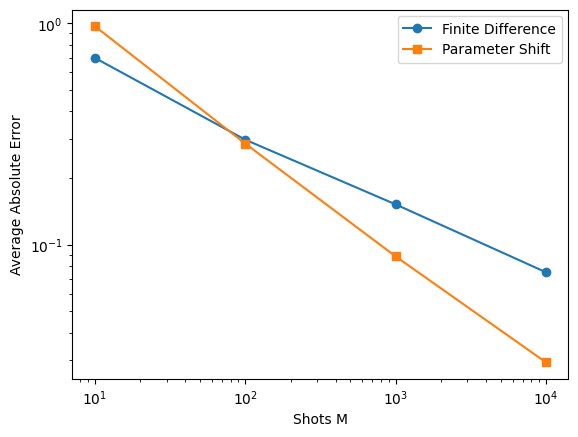

In [38]:
import matplotlib.pyplot as plt

plt.loglog(M_list, errors['finite_dif'], 'o-', label='Finite Difference')
plt.loglog(M_list, errors['param_shift'], 's-', label='Parameter Shift')
plt.xlabel('Shots M')
plt.ylabel('Average Absolute Error')
plt.legend()
plt.show()

### Acknowledgement:
- My computer cannot handle 10**5 shots, so I just skip this trial.
- I use all the gradients (**The gradient vector**) to calculate the average error instead of only the first qubit in the first layer.